In [1]:
# ======================================
# 📦 1. Setup and Imports
# ======================================
import os
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from datasets import load_dataset, concatenate_datasets, DatasetDict
from transformers import GPT2TokenizerFast, GPT2ForSequenceClassification, set_seed

/home2/shubhamcvit/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# ======================================
# 💾 2. Mount Google Drive
# ======================================
from google.colab import drive
drive.mount('/content/drive')

PROJECT_DIR = "/content/drive/MyDrive/gpt2_agnews_project"
MODEL_DIR = os.path.join(PROJECT_DIR, "model_output", "checkpoint-12760")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

Mounted at /content/drive
✅ Using device: cuda


In [2]:
MODEL_DIR = os.path.join("checkpoint-12760")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

✅ Using device: cuda


In [3]:
# ======================================
# 📂 3. Load and Recreate Dataset
# ======================================
SEED = 42
set_seed(SEED)

# Load AG News dataset
dataset = load_dataset("ag_news")

# Merge train + test, shuffle and re-split
full_dataset = concatenate_datasets([dataset["train"], dataset["test"]])
full_dataset = full_dataset.shuffle(seed=SEED)

# Create train (80%), validation (10%), test (10%)
train_testvalid = full_dataset.train_test_split(test_size=0.2, seed=SEED)
valid_test = train_testvalid["test"].train_test_split(test_size=0.5, seed=SEED)

dataset = DatasetDict({
    "train": train_testvalid["train"],
    "validation": valid_test["train"],
    "test": valid_test["test"]
})

print(dataset)
print(f"Train size: {len(dataset['train'])}")
print(f"Validation size: {len(dataset['validation'])}")
print(f"Test size: {len(dataset['test'])}")

# Extract test texts and labels
texts = dataset["test"]["text"]
labels = np.array(dataset["test"]["label"])

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 102080
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 12760
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12760
    })
})
Train size: 102080
Validation size: 12760
Test size: 12760


In [4]:
# ======================================
# 🤗 4. Load Tokenizer & Model
# ======================================
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_DIR)
model = GPT2ForSequenceClassification.from_pretrained(MODEL_DIR)
model.to(device)
model.eval()

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=4, bias=False)
)

In [5]:
# ======================================
# ⚙️ 5. Run Inference & Measure Latency
# ======================================
batch_size = 16
preds, latencies = [], []

with torch.no_grad():
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        encodings = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=256
        ).to(device)

        start = time.time()
        outputs = model(**encodings)
        end = time.time()

        # Measure latency per sample (ms)
        batch_latency = (end - start) * 1000 / len(batch_texts)
        latencies.append(batch_latency)

        batch_preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        preds.extend(batch_preds)

avg_latency = np.mean(latencies)
print(f"\n⚡ Average Inference Latency: {avg_latency:.2f} ms per sample")


⚡ Average Inference Latency: 1.01 ms per sample


In [7]:
# ======================================
# 📊 6. Performance Metrics
# ======================================
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

print("\n📈 Performance Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")


📈 Performance Metrics:
Accuracy : 0.9441
Precision: 0.9439
Recall   : 0.9441
F1-Score : 0.9440


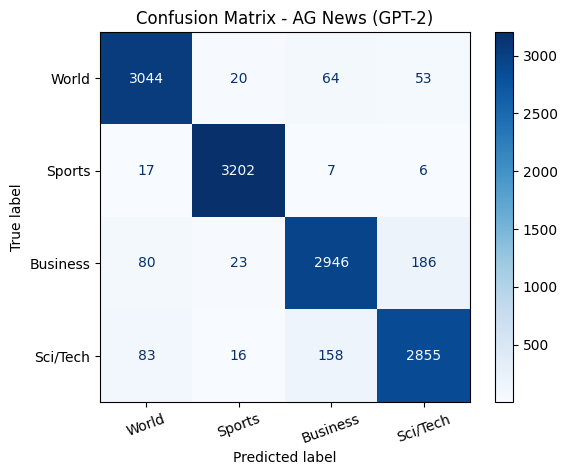

In [8]:
# ======================================
# 🧮 7. Confusion Matrix Visualization
# ======================================
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["World", "Sports", "Business", "Sci/Tech"])
disp.plot(cmap="Blues", xticks_rotation=20)
plt.title("Confusion Matrix - AG News (GPT-2)")
plt.show()

In [ ]:
# ======================================
# 💡 8. Efficiency: Memory Footprint
# ======================================
def get_disk_model_size(model_dir):
    """Compute total disk size of model checkpoint folder (MB)."""
    total_bytes = 0
    for root, _, files in os.walk(model_dir):
        for f in files:
            total_bytes += os.path.getsize(os.path.join(root, f))
    return total_bytes / (1024**2)  # MB


def get_parameter_memory(model):
    """Compute in-memory size of all model parameters (MB)."""
    total_bytes = 0
    for param in model.parameters():
        total_bytes += param.nelement() * param.element_size()
    return total_bytes / (1024**2)  # MB


def get_buffer_memory(model):
    """Include non-trainable buffers (e.g., running_mean, running_var)."""
    total_bytes = 0
    for buf in model.buffers():
        total_bytes += buf.nelement() * buf.element_size()
    return total_bytes / (1024**2)


# Compute both footprint types
disk_size = get_disk_model_size(MODEL_DIR)
param_mem = get_parameter_memory(model)
buffer_mem = get_buffer_memory(model)
true_model_mem = param_mem + buffer_mem

print(f"\n💾 Disk Checkpoint Size: {disk_size:.2f} MB")
print(f"🧠 Model Parameter Memory (in RAM): {true_model_mem:.2f} MB")
print(f"    ├── Parameters: {param_mem:.2f} MB")
print(f"    └── Buffers:    {buffer_mem:.2f} MB")



💾 Disk Checkpoint Size: 1428.89 MB
🧠 Model Parameter Memory (in RAM): 486.71 MB
    ├── Parameters: 474.71 MB
    └── Buffers:    12.00 MB


: 